In [1]:
from emap_tools import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.mplot3d import Axes3D

## Load CSV exported from online spreadsheet

In [2]:
df_modules = pd.read_csv("hgcal_modules_sheet_v1.csv")

Drop rows where all columns are `nan`

In [3]:
df_modules.dropna(how='all',inplace=True)

Add 28 to the FH layer numbers

In [4]:
df_modules.loc[df_modules['Sub- detector'] == 'FH', 'Layer'] += 28

In [5]:
df_modules.head()

,ID,Detector label,Production year,PCB version,Sensor thickness [um],Baseplate material,Baseplate thickness [mm],I_leak [uA] @ 200V,I_leak [uA] @ 250V,Bad chans,...,EE Casette,EE position,FH position,Rotation,Readout Board,EUDAQ RB IDX,RB Slot,EUDAQ Slot IDX,T Sensor,RH Sensor
0,78,EE_1,2018,v3,300,CuW,1.2,0.156,0.171,?,...,1,front,–,60.0,65,NaN,1,1,NaN,NaN
1,90,EE_2,2018,v3,300,CuW,1.2,0.123,0.14,?,...,1,back,–,60.0,65,NaN,3,2,NaN,NaN
2,89,EE_3,2018,v3,300,CuW,1.2,0.135,0.182,?,...,2,front,–,60.0,65,NaN,4,3,NaN,NaN
3,88,EE_4,2018,v3,300,Cuw,1.2,0.093,0.119,?,...,2,back,–,60.0,65,NaN,5,4,NaN,NaN
4,77,EE_5,2018,v3,300,CuW,1.2,0.164,3.98,?,...,3,front,–,60.0,65,NaN,6,5,NaN,NaN


### Assign an order index to the RBs based on their order of appearance

In [6]:
rb_ids = df_modules['Readout Board'].unique()
d_rb_ids = {rb_id:idx for idx,rb_id in enumerate(rb_ids)}
d_rb_ids

{51: 13,
 52: 12,
 53: 11,
 54: 10,
 55: 9,
 56: 8,
 57: 7,
 58: 6,
 59: 5,
 60: 4,
 61: 3,
 62: 2,
 63: 1,
 65: 0}

In [7]:
df_modules['EUDAQ RB IDX'] = df_modules['Readout Board'].map(d_rb_ids)

In [8]:
df_modules['EUDAQ Module IDX'] = df_modules['EUDAQ RB IDX'] * 10 + df_modules['EUDAQ Slot IDX']-1

### Sort modules by EUDAQ Module IDX

Since this is the order the modules appear in the data stream

In [9]:
df_modules.sort_values(by ='EUDAQ Module IDX', inplace=True)

In [10]:
#df_modules.filter(regex = 'EUD')

In [11]:
#ee_positions = {"angle": 60, "module_IX": 0, "module_IV": 0}

In [12]:
fh_positions = {
    1: {"angle": 180, "module_IX": -1, "module_IV": 0},
    2: {"angle": 180, "module_IX": 0, "module_IV": -1},
    3: {"angle": 180, "module_IX": 1, "module_IV": -1},
    4: {"angle": 180, "module_IX": 0, "module_IV": 0},
    5: {"angle": 0, "module_IX": -1, "module_IV": 1},
    6: {"angle": 0, "module_IX": 0, "module_IV": 1},
    7: {"angle": 0, "module_IX": 1, "module_IV": 0}
}

In [13]:
d_modules = df_modules.T.to_dict()
modules = []

for idx,mod in d_modules.iteritems():
    
    mod_params = {}
    mod_params['ID'] = int(mod['ID'])
    mod_params['layer'] = int(mod['Layer'])
    mod_params['pcb_version'] = mod['PCB version']
    
    subdet = mod['Sub- detector']
    mod_params['subdet'] = subdet
    
    if subdet == 'EE':
        mod_params['facing'] = mod['EE position']
        mod_params['angle'] = 60#int(mod['Rotation'])
        mod_params['module_IX'] = 0
        mod_params['module_IV'] = 0
        
        mod['module_IX'] = 0
        mod['module_IV'] = 0
        
    elif subdet == 'FH': 
        mod_params['facing'] = 'front'
        fh_pos_id = int(mod['FH position'])
        if fh_pos_id not in fh_positions: print fh_pos_id, ' not in fh_positions!'
        else:
            pos = fh_positions[fh_pos_id]
            mod_params.update(pos)
            mod.update(pos)

    else:
        print 'Unrecognized subdetector!', subdet
    
    module = Module(**mod_params)
    module.index = idx
    modules.append(module)
    #print Module(**mod_params)

Created: module ID 78, layer 1, PCB version v3
Rotating by angle 60
Created: module ID 90, layer 2, PCB version v3
Flipping horizontally, facing backwards
Rotating by angle 60
Created: module ID 89, layer 3, PCB version v3
Rotating by angle 60
Created: module ID 88, layer 4, PCB version v3
Flipping horizontally, facing backwards
Rotating by angle 60
Created: module ID 77, layer 5, PCB version v3
Rotating by angle 60
Created: module ID 85, layer 6, PCB version v3
Flipping horizontally, facing backwards
Rotating by angle 60
Created: module ID 84, layer 7, PCB version v3
Rotating by angle 60
Created: module ID 32, layer 8, PCB version v3
Flipping horizontally, facing backwards
Rotating by angle 60
Created: module ID 69, layer 9, PCB version v3
Rotating by angle 60
Created: module ID 79, layer 10, PCB version v3
Flipping horizontally, facing backwards
Rotating by angle 60
Created: module ID 76, layer 11, PCB version v3
Rotating by angle 60
Created: module ID 83, layer 12, PCB version v3
Fl

### Create global chip numbering based on the module index

In [14]:
for m in modules: m.channels.CHIP = m.channels.CHIP + m.index * 4

## Write out channel emap

In [15]:
labels = ['CHIP' , 'CHANNEL' , 'layer','module_IX',  'module_IV' , 'IX',  'IV' , 'TYPE']

foutname = 'test_emap_full_v1.txt'

with open(foutname,'w') as emapfile:
    for module in modules:
        emapfile.write(module.channels[labels].to_string(index=False) + '\n')

In [16]:
! head test_emap_full_v1.txt
print 60*"#"
! tail test_emap_full_v1.txt

CHIP  CHANNEL  layer  module_IX  module_IV  IX  IV  TYPE
   1        0      1          0          0  -3   5     0
   1        2      1          0          0  -2   4     0
   1        4      1          0          0  -3   4     0
   1        6      1          0          0  -4   6     0
   1        8      1          0          0  -3   3     0
   1       10      1          0          0  -5   6     2
   1       12      1          0          0  -4   5     0
   1       14      1          0          0  -2   2     0
   1       16      1          0          0  -2   3     0
############################################################
 376       44     40          0          0   1   0     0
 376       46     40          0          0   3   1     0
 376       48     40          0          0   4   0     0
 376       50     40          0          0   5   0     0
 376       52     40          0          0   2   1     0
 376       54     40          0          0   1   1     0
 376       56     40       

## Layer geom

In [17]:
foutname = 'layer_geom_full_v1.txt'

with open(foutname,'w') as geomfile:
    for idx,mod in d_modules.iteritems():

        subdet = mod['Sub- detector']
        
        wstring = "%i \t %i\t%s\t%i\t%i\t%i\n" %(mod['Layer'],  1-(subdet == 'EE'), subdet, mod['module_IX'], mod['module_IV'], mod['ID'])
        
        geomfile.write(wstring)

In [18]:
! head layer_geom_full_v1.txt
print 45*"#"
! tail layer_geom_full_v1.txt

1 	 0	EE	0	0	78
2 	 0	EE	0	0	90
3 	 0	EE	0	0	89
4 	 0	EE	0	0	88
5 	 0	EE	0	0	77
6 	 0	EE	0	0	85
7 	 0	EE	0	0	84
8 	 0	EE	0	0	32
9 	 0	EE	0	0	69
10 	 0	EE	0	0	79
#############################################
30 	 1	FH	-1	0	75
30 	 1	FH	0	-1	59
30 	 1	FH	1	-1	71
30 	 1	FH	0	0	64
30 	 1	FH	-1	1	55
30 	 1	FH	0	1	63
30 	 1	FH	1	0	66
38 	 1	FH	0	0	62
39 	 1	FH	0	0	54
40 	 1	FH	0	0	43


## Plotting

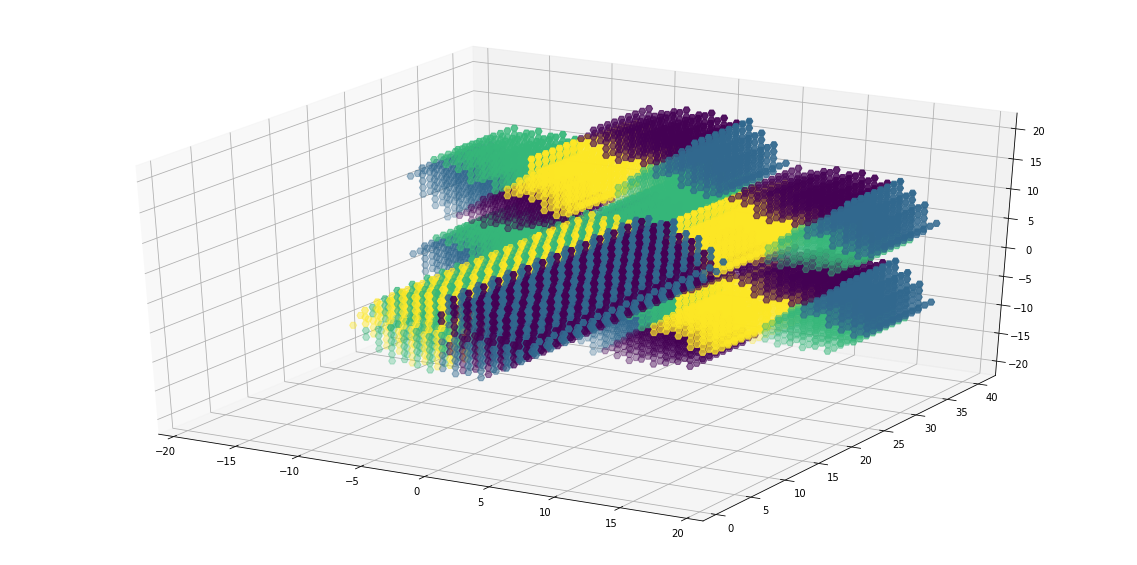

In [19]:
bad_chans = [(2,20),(2,22),(2,12),(2,8),(2,10)] # HDMI side

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')

cmap = 'viridis'
m_style = 'H'
m_size = 50


for m in modules:
    #print '## Plotting', m
    #m.mark_bad_chans(bad_chans)

    x,y = m.get_chan_xy(angle = 30)

    sel = m.channels.bad == False
    ax.scatter(x[sel],m.channels.layer[sel] ,y[sel], c = m.channels.CHIP[sel], cmap = cmap, s = m_size, marker = m_style)

plt.grid()
plt.show()

In [20]:
dfs = []

for m in modules:
    x,y = m.get_chan_xy(angle = 30)

    d = {}
    d['x'] = x
    d['y'] = y
    d['z'] = m.channels.layer
    d['c'] = m.ID
 
    dfs.append(pd.DataFrame(d))
    
df_xyz = pd.concat(dfs)

In [21]:
df_xyz = df_xyz[::-1]

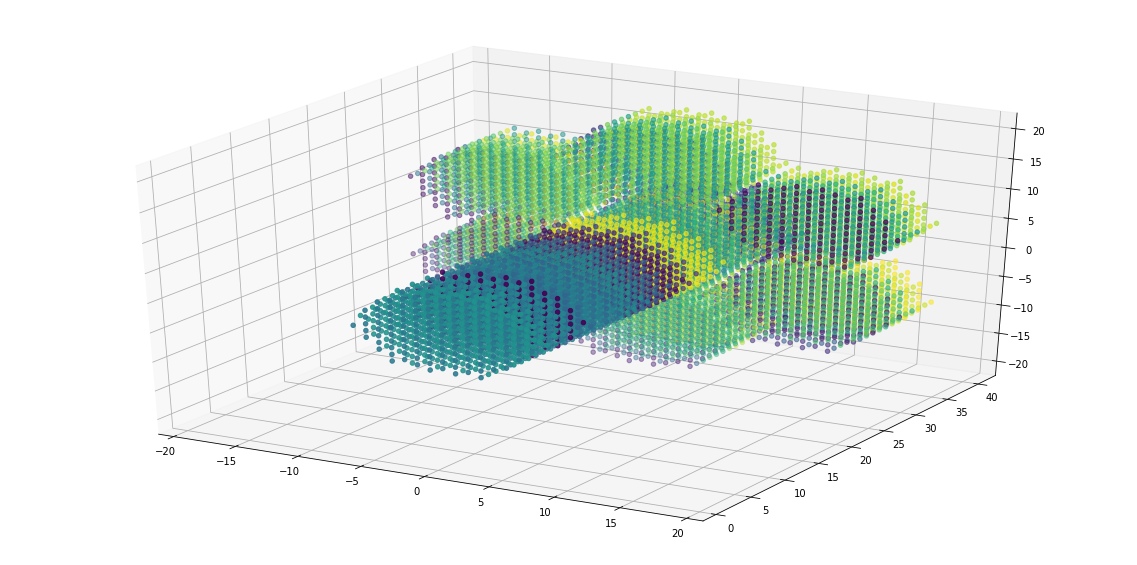

In [22]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_xyz.x, df_xyz.z, df_xyz.y, c = df_xyz.c, cmap = 'viridis')

plt.show()

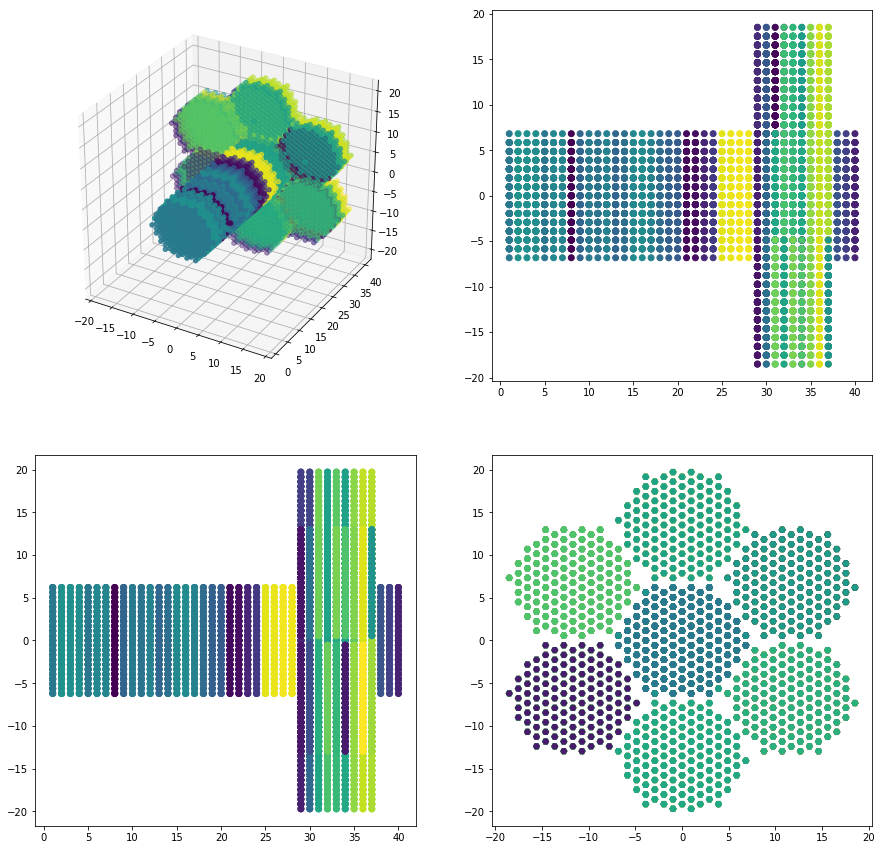

In [24]:
fig = plt.figure(figsize = (15,15))

m_style = 'H'

ax = fig.add_subplot(221, projection='3d')
ax.scatter(df_xyz.x, df_xyz.z, df_xyz.y, c = df_xyz.c, cmap = 'viridis')

ax = fig.add_subplot(222)#, projection='3d')
ax.scatter(df_xyz.z, df_xyz.x, c = df_xyz.c, cmap = 'viridis')

ax = fig.add_subplot(223)#, projection='3d')
ax.scatter(df_xyz.z, df_xyz.y, c = df_xyz.c, cmap = 'viridis')

ax = fig.add_subplot(224)#, projection='3d')
ax.scatter(df_xyz.x, df_xyz.y, c = df_xyz.c, cmap = 'viridis', marker = m_style)


plt.show()